# Relatório final dos principais gargalos para o aumento de conversão

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [2]:
df = pd.read_excel("C:/Users/rayne/Downloads/df_case_ANALISTA_DE_DADOS_ROBERTO.xlsx", decimal= ',')
df['mes'] = df['lead_in'].dt.month

## Replicando o funil do case

In [3]:
tabela_funil = df.groupby(['mes'],as_index = False)[['lead_in','bill_uploaded', 'lead_approved_eligible',
       'proposal_sent','contract_signed', 'homologation_date']].count()
tabela_funil

,mes,lead_in,bill_uploaded,lead_approved_eligible,proposal_sent,contract_signed,homologation_date
0,1,175,79,72,70,22,19
1,2,116,56,52,51,13,8
2,3,748,452,205,177,72,65
3,4,899,475,215,190,78,62
4,5,1303,879,376,338,126,99
5,6,1443,918,451,304,119,91
6,7,555,369,260,110,76,62
7,8,1889,1629,741,479,338,289


### Criando colunas que serão utilizadas nas análises

In [4]:
df_analise = pd.DataFrame(df)

df_analise['mes'] = df_analise['lead_in'].dt.month
my_dict = {1:"Janeiro", 2: "Fevereiro",3:"Março",4:"Abril",5:"Maio",6:"Junho",7:"Julho",8:"Agosto",9:"Setembto",10:"Outubro",
           11:"Novembro",12:"Dezembro"}
df_analise['mes_por_extenso']= df_analise['mes'].map(my_dict)

## Adicionando algumas colunas que serão utilizadas na análise 

df_analise['fatura_carregada'] = None
for i in range(len(df_analise)):
    if pd.isna(df_analise['bill_uploaded'][i]):
        df_analise.loc[0:,'fatura_carregada'][i] = 'Fatura não carregada'
    else:
        df_analise.loc[0:,'fatura_carregada'][i] = 'Fatura carregada'
        
df_analise['conversao'] = None
for i in range(len(df_analise)):
    if pd.isna(df_analise['lost_date'][i]):
        df_analise.loc[0:,'conversao'][i] = 1
    else:
        df_analise.loc[0:,'conversao'][i] = 0

df_analise['elegivel'] = None
for i in range(len(df_analise)):
    if pd.isna(df_analise['lead_approved_eligible'][i]):
        df_analise.loc[0:,'elegivel'][i] = 0
    else:
        df_analise.loc[0:,'elegivel'][i] = 1
        
df_analise['homologado'] = None
for i in range(len(df_analise)):
    if pd.isna(df_analise['homologation_date'][i]):
        df_analise.loc[0:,'homologado'][i] = 0
    else:
        df_analise.loc[0:,'homologado'][i] = 1               

###### motivos de perda
motivos_de_perda = ['Consumo muito baixo','Não houve contato','Card Duplicado','Sem interesse']
lost_reason_Top4 = df_analise.query('lostReason in @motivos_de_perda')
df_analise['lost_reason_Top4'] = lost_reason_Top4['lostReason']
x =pd.get_dummies(lost_reason_Top4['lostReason'])
df_analise=pd.concat([x,df_analise],axis = 1)                 

##### de onde o usuário chegou
fonte_utm = ['Ambev','Facebook','site','iFood']
utm_source_top4 = df_analise.query('utmSource in @fonte_utm')

df_analise['utmSource_Top4'] = utm_source_top4['utmSource']

z =pd.get_dummies(utm_source_top4['utmSource'])
df_analise=pd.concat([z,df_analise],axis = 1)                 

a =pd.get_dummies(df_analise['billDocumentType'])
df_analise=pd.concat([a,df_analise],axis = 1) 

### Estágio Atual do Lead

etapa_lead = ['leadAnalyzed','leadCreated']  

etapa_lead_top2 = df_analise.query('stage in @etapa_lead')

df_analise['etapa_lead_top2'] = etapa_lead_top2['stage']        

df_analise

,pessoa física,pessoa jurídica,Ambev,Facebook,iFood,site,Card Duplicado,Consumo muito baixo,Não houve contato,Sem interesse,...,billDocumentType,mes,mes_por_extenso,fatura_carregada,conversao,elegivel,homologado,lost_reason_Top4,utmSource_Top4,etapa_lead_top2
0,1,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,pessoa física,1,Janeiro,Fatura carregada,0,0,0,Consumo muito baixo,Ambev,leadAnalyzed
1,1,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,pessoa física,1,Janeiro,Fatura não carregada,0,0,0,Consumo muito baixo,Ambev,leadAnalyzed
4,1,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,pessoa física,1,Janeiro,Fatura não carregada,0,1,0,Não houve contato,Ambev,NaN
7,1,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,pessoa física,1,Janeiro,Fatura não carregada,0,0,0,Consumo muito baixo,Ambev,leadAnalyzed
8,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,pessoa física,1,Janeiro,Fatura não carregada,0,1,0,Sem interesse,Ambev,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7041,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,pessoa física,8,Agosto,Fatura carregada,0,1,0,NaN,NaN,NaN
7042,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,pessoa jurídica,8,Agosto,Fatura carregada,0,0,0,NaN,NaN,leadAnalyzed
7047,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,pessoa física,8,Agosto,Fatura não carregada,1,0,0,NaN,NaN,leadCreated
7099,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,pessoa física,8,Agosto,Fatura carregada,0,0,0,NaN,NaN,leadAnalyzed


## Analisando onde estão parando os Leads

In [5]:
fat_upload= df_analise.where(df['homologado']==1).groupby(['mes','mes_por_extenso'],as_index = False)\
[['fatura_carregada']].value_counts()

temp_fat = df_analise.where(df['homologado']==1).groupby(['mes_por_extenso'],as_index = False)\
[['homologation_date']].count()
fat_upload = pd.merge(fat_upload,temp_fat,on='mes_por_extenso', how = 'outer')

fat_upload['percent_fat_homologada'] = ((fat_upload['count']/fat_upload['homologation_date'])*100).round(2)


fat_upload

,mes,mes_por_extenso,fatura_carregada,count,homologation_date,percent_fat_homologada
0,1.0,Janeiro,Fatura carregada,13,19,68.42
1,1.0,Janeiro,Fatura não carregada,6,19,31.58
2,2.0,Fevereiro,Fatura carregada,5,8,62.50
3,2.0,Fevereiro,Fatura não carregada,3,8,37.50
4,3.0,Março,Fatura carregada,61,65,93.85
5,3.0,Março,Fatura não carregada,4,65,6.15
6,4.0,Abril,Fatura carregada,48,62,77.42
7,4.0,Abril,Fatura não carregada,14,62,22.58
8,5.0,Maio,Fatura carregada,98,99,98.99
9,5.0,Maio,Fatura não carregada,1,99,1.01


In [6]:
#### Sabendo que os dois principais Stages são Lead Analyzed e Lead Created, a análise será em cima deles

n_homologado_por_etapa = df_analise.where(df['homologado']==0).groupby(['mes','mes_por_extenso'],as_index = False)\
['etapa_lead_top2'].value_counts()

temp = df_analise.groupby(['mes'],as_index = False)[['lead_in']].count()

n_homologado_por_etapa = pd.merge(temp,n_homologado_por_etapa,on='mes', how = 'outer') 
n_homologado_por_etapa['percent_lead_n_homologado'] = ((n_homologado_por_etapa['count']/n_homologado_por_etapa['lead_in'])*100)\
.round(2)

n_homologado_por_etapa

,mes,lead_in,mes_por_extenso,etapa_lead_top2,count,percent_lead_n_homologado
0,1,175,Janeiro,leadAnalyzed,49,28.00
1,1,175,Janeiro,leadCreated,40,22.86
2,2,116,Fevereiro,leadCreated,34,29.31
3,2,116,Fevereiro,leadAnalyzed,8,6.90
4,3,748,Março,leadCreated,278,37.17
5,3,748,Março,leadAnalyzed,237,31.68
6,4,899,Abril,leadCreated,390,43.38
7,4,899,Abril,leadAnalyzed,284,31.59
8,5,1303,Maio,leadAnalyzed,488,37.45
9,5,1303,Maio,leadCreated,407,31.24


In [7]:
df_taxa_de_coversao = df_analise.groupby(['mes','mes_por_extenso'],as_index = False)\
[['lead_in','bill_uploaded', 'lead_approved_eligible',
       'proposal_sent','contract_signed', 'homologation_date']].count()
df_taxa_de_coversao['coversao_percent']= ((df_taxa_de_coversao['homologation_date']/df_taxa_de_coversao['lead_in'])*100)\
.round(2)

df_taxa_de_coversao

,mes,mes_por_extenso,lead_in,bill_uploaded,lead_approved_eligible,proposal_sent,contract_signed,homologation_date,coversao_percent
0,1,Janeiro,175,79,72,70,22,19,10.86
1,2,Fevereiro,116,56,52,51,13,8,6.90
2,3,Março,748,452,205,177,72,65,8.69
3,4,Abril,899,475,215,190,78,62,6.90
4,5,Maio,1303,879,376,338,126,99,7.60
5,6,Junho,1443,918,451,304,119,91,6.31
6,7,Julho,555,369,260,110,76,62,11.17
7,8,Agosto,1889,1629,741,479,338,289,15.30


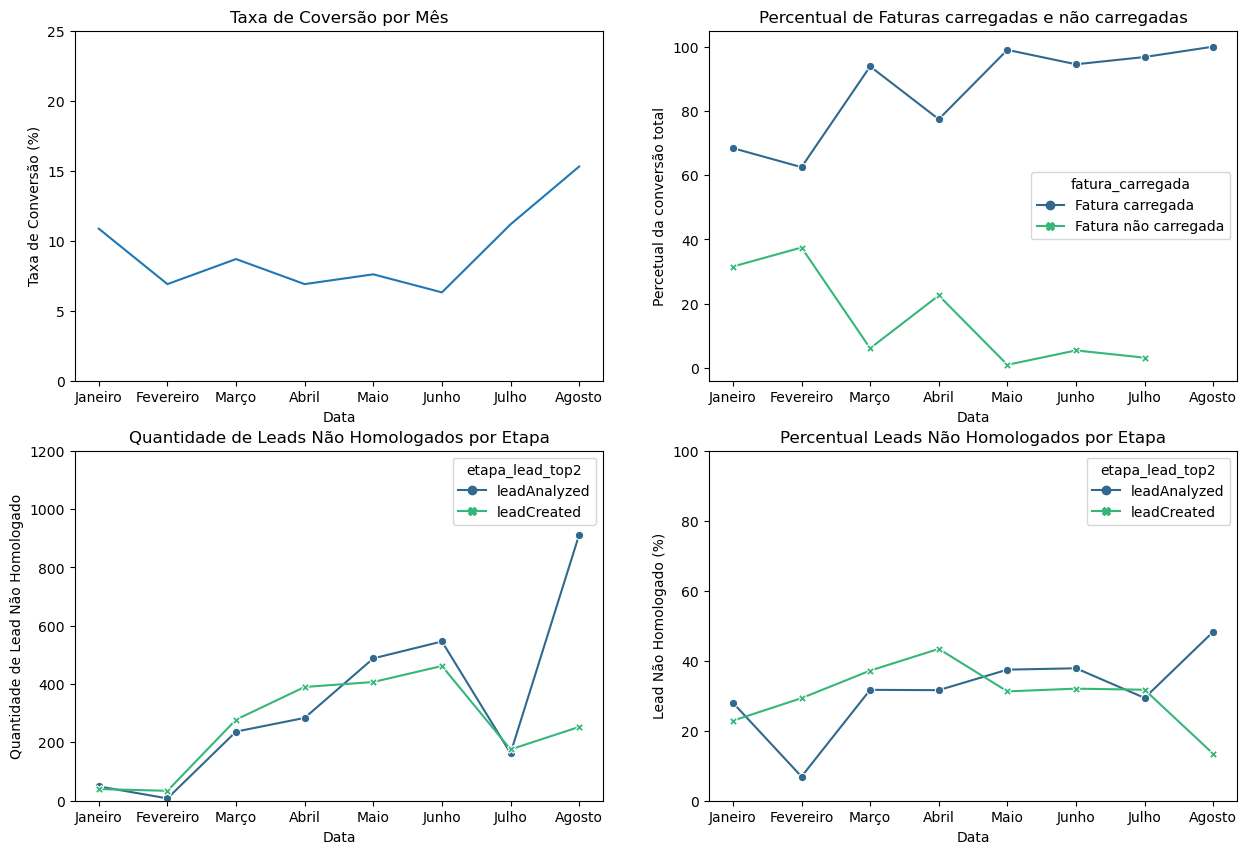

In [8]:
# Criando a figura
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
# plt.style.use('ggplot')
#palette = sns.color_palette("mako_r", 2)

# Gráfico 1
sns.lineplot(data=df_taxa_de_coversao, x="mes_por_extenso", y="coversao_percent",markers=True, dashes = False, ax=axs[0,0])
axs[0,0].set_ylim([0,25])
axs[0,0].set_ylabel('Taxa de Conversão (%)')
axs[0,0].set_xlabel('Data')
# Gráfico 2

sns.lineplot(data=fat_upload, x="mes_por_extenso", y="percent_fat_homologada", hue="fatura_carregada",
             style = 'fatura_carregada',
             palette='viridis',markers=True, dashes = False, ax=axs[0,1])
axs[0,1].set_ylabel('Percetual da conversão total')
axs[0,1].set_xlabel('Data')

# Gráfico 3
sns.lineplot(data=n_homologado_por_etapa, x="mes_por_extenso", y="count", hue="etapa_lead_top2",style = 'etapa_lead_top2',
             palette='viridis',markers=True, dashes = False, ax=axs[1,0])

axs[1,0].set_ylim([0,1200])
axs[1,0].set_ylabel('Quantidade de Lead Não Homologado')
axs[1,0].set_xlabel('Data')

# Gráfico 4
sns.lineplot(data=n_homologado_por_etapa, x="mes_por_extenso", y="percent_lead_n_homologado", hue="etapa_lead_top2"
             ,style = 'etapa_lead_top2',
             palette='viridis',markers=True, dashes = False, ax=axs[1,1])
axs[1,1].set_ylim([0,100])
axs[1,1].set_ylabel('Lead Não Homologado (%)')
axs[1,1].set_xlabel('Data')

# Adicionando títulos aos gráficos
axs[0,0].set_title('Taxa de Coversão por Mês')
axs[0,1].set_title('Percentual de Faturas carregadas e não carregadas')
axs[1,0].set_title('Quantidade de Leads Não Homologados por Etapa')
axs[1,1].set_title('Percentual Leads Não Homologados por Etapa')

# Exibindo a figura
plt.show()

## Gráficos de barra de motivo de perda, conversão por Classe (PJ X PF) e Etapa

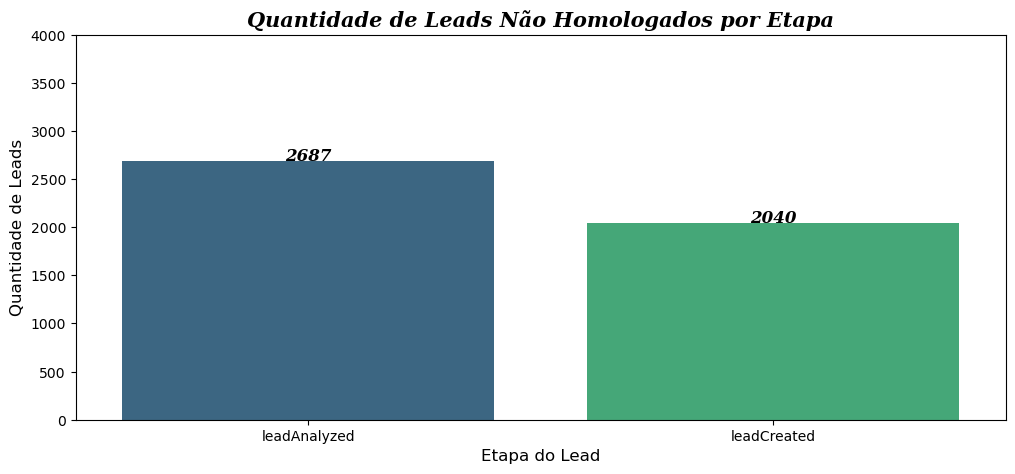

In [9]:
### Quais or principais motivos de perda dos não homologados que não importam a conta?

temp_bar = df_analise.where(df_analise['homologado']==0)[['etapa_lead_top2']].value_counts().reset_index()

temp_bar.rename(columns={0:'quantidade_de_leads'},inplace=True)
df = pd.DataFrame(temp_bar)

fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x="etapa_lead_top2", y="quantidade_de_leads", data=df,linewidth=2, palette='viridis',ax = ax)

ax.set_ylim([0,4000])
ax.set_title('Quantidade de Leads Não Homologados por Etapa',fontsize = 15, fontweight ='bold',fontstyle ='italic'
             ,fontfamily ='serif')
ax.set_ylabel('Quantidade de Leads',fontsize= 12)
ax.set_xlabel('Etapa do Lead',fontsize= 12)

# Adicionando os valores nas colunas
for i in range(len(df)):
    plt.text(x=i, y=df['quantidade_de_leads'][i]+5, s=df['quantidade_de_leads'][i], ha='center', fontsize=12
            ,fontweight ='bold',fontstyle ='italic',fontfamily ='serif')



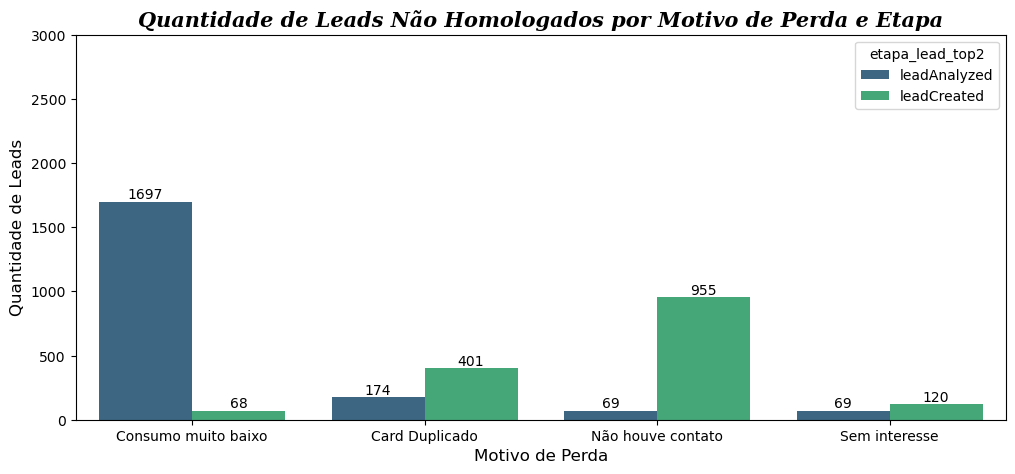

In [10]:
temp_bar = df_analise.where((df_analise['homologado']==0)).groupby(['etapa_lead_top2'])\
[['lost_reason_Top4']].value_counts().reset_index()

temp_bar.rename(columns={0:'quantidade_de_leads'},inplace=True)
n_homologado_motivo_perda = pd.DataFrame(temp_bar)


fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x="lost_reason_Top4", y="quantidade_de_leads",hue='etapa_lead_top2', data=n_homologado_motivo_perda,linewidth=2, 
            palette='viridis',ax = ax)

ax.set_ylim([0,3000])
ax.set_title('Quantidade de Leads Não Homologados por Motivo de Perda e Etapa',fontsize = 15, fontweight ='bold'
             ,fontstyle ='italic'
             ,fontfamily ='serif')
ax.set_ylabel('Quantidade de Leads',fontsize= 12)
ax.set_xlabel('Motivo de Perda',fontsize= 12)

for i in ax.containers:
    ax.bar_label(i,)


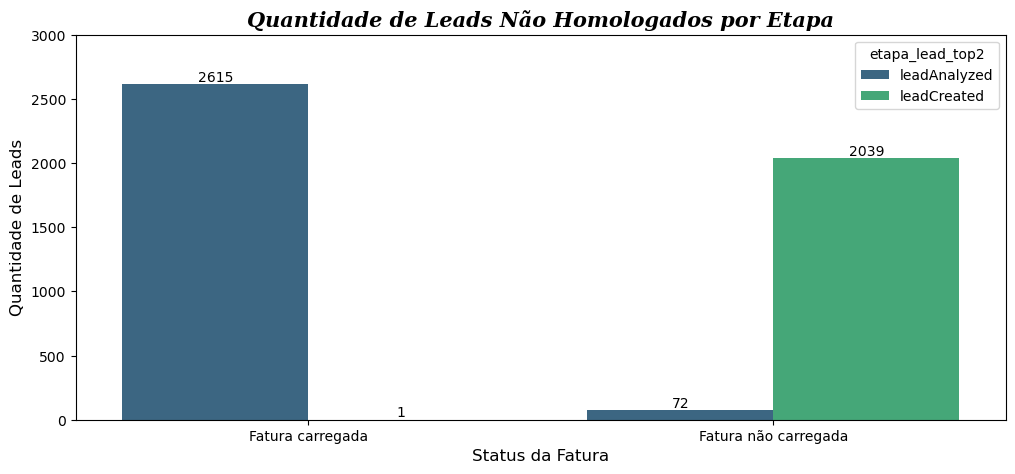

In [28]:
temp_bar = df_analise.where((df_analise['homologado']==0)).groupby(['fatura_carregada'])\
[['etapa_lead_top2']].value_counts().reset_index()

temp_bar.rename(columns={0:'quantidade_de_leads'},inplace=True)
n_homologado_motivo_perda = pd.DataFrame(temp_bar)


fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x="fatura_carregada", y="quantidade_de_leads",hue='etapa_lead_top2', data=n_homologado_motivo_perda,linewidth=2, 
            palette='viridis',ax = ax)

ax.set_ylim([0,3000])
ax.set_title('Quantidade de Leads Não Homologados por Etapa',fontsize = 15, fontweight ='bold',fontstyle ='italic'
             ,fontfamily ='serif')
ax.set_ylabel('Quantidade de Leads',fontsize= 12)
ax.set_xlabel('Status da Fatura',fontsize= 12)

for i in ax.containers:
    ax.bar_label(i,)

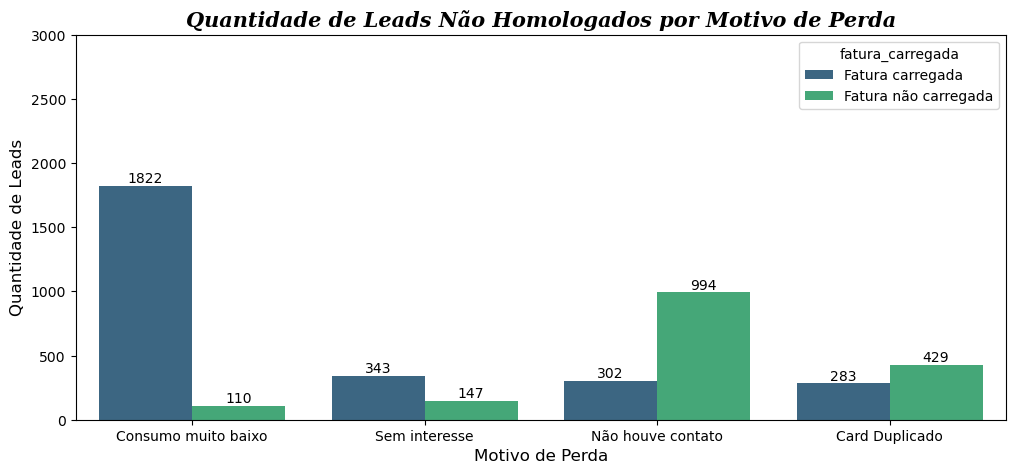

In [12]:
temp_bar = df_analise.where((df_analise['homologado']==0)).groupby(['fatura_carregada'])\
[['lost_reason_Top4']].value_counts().reset_index()

temp_bar.rename(columns={0:'quantidade_de_leads'},inplace=True)
n_homologado_motivo_perda = pd.DataFrame(temp_bar)


fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x="lost_reason_Top4", y="quantidade_de_leads",hue='fatura_carregada', data=n_homologado_motivo_perda,linewidth=2, 
            palette='viridis',ax = ax)

ax.set_ylim([0,3000])
ax.set_title('Quantidade de Leads Não Homologados por Motivo de Perda',fontsize = 15, fontweight ='bold',fontstyle ='italic'
             ,fontfamily ='serif')
ax.set_ylabel('Quantidade de Leads',fontsize= 12)
ax.set_xlabel('Motivo de Perda',fontsize= 12)

for i in ax.containers:
    ax.bar_label(i,)

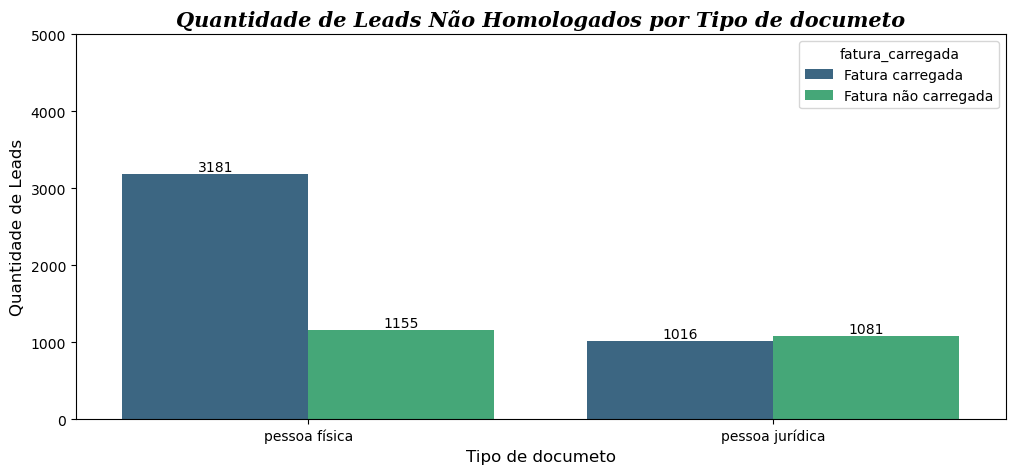

In [13]:
temp_bar = df_analise.where((df_analise['homologado']==0)).groupby(['fatura_carregada'])\
[['billDocumentType']].value_counts().reset_index()

temp_bar.rename(columns={0:'quantidade_de_leads'},inplace=True)
n_homologado_tipo_doc = pd.DataFrame(temp_bar)


fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x="billDocumentType", y="quantidade_de_leads",hue='fatura_carregada', data=n_homologado_tipo_doc,linewidth=2, 
           palette='viridis',ax = ax)

ax.set_ylim([0,5000])
ax.set_title('Quantidade de Leads Não Homologados por Tipo de documeto',fontsize = 15, fontweight ='bold',fontstyle ='italic'
             ,fontfamily ='serif')
ax.set_ylabel('Quantidade de Leads',fontsize= 12)
ax.set_xlabel('Tipo de documeto',fontsize= 12)

for i in ax.containers:
    ax.bar_label(i,)


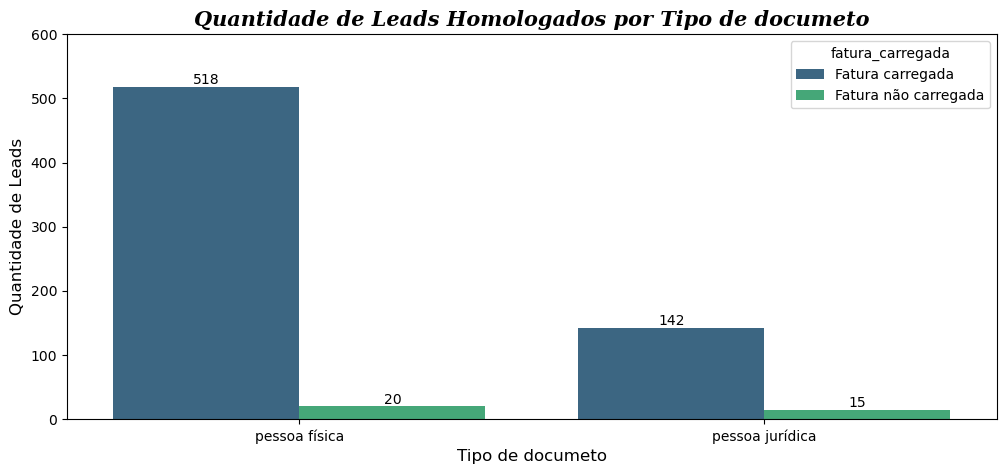

In [14]:
temp_bar = df_analise.where((df_analise['homologado']==1)).groupby(['fatura_carregada'])\
[['billDocumentType']].value_counts().reset_index()

temp_bar.rename(columns={0:'quantidade_de_leads'},inplace=True)
homologado_por_tipo_doc = pd.DataFrame(temp_bar)


fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x="billDocumentType", y="quantidade_de_leads",hue='fatura_carregada', data=homologado_por_tipo_doc,linewidth=2, 
            palette='viridis',ax = ax)

ax.set_ylim([0,600])
ax.set_title('Quantidade de Leads Homologados por Tipo de documeto',fontsize = 15, fontweight ='bold',fontstyle ='italic'
             ,fontfamily ='serif')
ax.set_ylabel('Quantidade de Leads',fontsize= 12)
ax.set_xlabel('Tipo de documeto',fontsize= 12)

for i in ax.containers:
    ax.bar_label(i,)


## Como a base é completamente desbalanceada quanto a quantidade de lads por estado, não faz sentido avaliar os dados por estado

In [15]:
df_analise.groupby(['state'])[['lead_in']].count().reset_index()

,state,lead_in
0,AL,1
1,DF,52
2,ES,1
3,MG,6986
4,MT,1
5,PB,1
6,PE,68
7,PR,2
8,RS,1
9,SC,1


In [16]:
df_analise.where(df_analise['homologado']==1).groupby(['state'])[['homologation_date']].count().reset_index()

,state,homologation_date
0,DF,4
1,MG,689
2,PE,2


## Análise e resposta da segunda pergunta, que é :  Qual a sua sugestão de plano de ação para resolver os gargalos e melhorar nosso resultado?

In [17]:
table_a= df_analise.groupby(['mes'],as_index = False)[['lead_in','bill_uploaded', 'lead_approved_eligible',
       'proposal_sent','contract_signed', 'homologation_date','lost_date']].count()

table_a['coversao_percent']= ((table_a['homologation_date']/table_a['lead_in'])*100).round(2)
table_a['contas_recebidas_percent']= ((table_a['bill_uploaded']/table_a['lead_in'])*100).round(2)
table_a['contas_elegiveis_percent']= ((table_a['lead_approved_eligible']/table_a['lead_in'])*100).round(2)
pessoa_fisica_e_juridica = df_analise.groupby(['mes'],as_index = False)[['pessoa física','pessoa jurídica']].sum()

table_a=pd.merge(pessoa_fisica_e_juridica,table_a,on='mes', how = 'outer') 

table_a.rename(columns={'bill_uploaded':'Contas Recebidas', 'lead_approved_eligible':'Contas Elegíveis',
       'proposal_sent':'Propostas Enviadas', 'contract_signed':'Contratos Assinados',
                        'homologation_date':'Contratos Homologados'},inplace = True)
table_a

,mes,pessoa física,pessoa jurídica,lead_in,Contas Recebidas,Contas Elegíveis,Propostas Enviadas,Contratos Assinados,Contratos Homologados,lost_date,coversao_percent,contas_recebidas_percent,contas_elegiveis_percent
0,1,127.0,48.0,175,79,72,70,22,19,156,10.86,45.14,41.14
1,2,55.0,61.0,116,56,52,51,13,8,109,6.90,48.28,44.83
2,3,495.0,253.0,748,452,205,177,72,65,688,8.69,60.43,27.41
3,4,548.0,351.0,899,475,215,190,78,62,845,6.90,52.84,23.92
4,5,916.0,387.0,1303,879,376,338,126,99,1218,7.60,67.46,28.86
5,6,1003.0,440.0,1443,918,451,304,119,91,1263,6.31,63.62,31.25
6,7,316.0,239.0,555,369,260,110,76,62,358,11.17,66.49,46.85
7,8,1414.0,475.0,1889,1629,741,479,338,289,1400,15.30,86.24,39.23


In [18]:
table_a['coversao_percent'].mean()

9.21625

In [19]:
## Como é preciso aumentar nossa taxa de conversão de leads para leads homologados em 30% nos próximos 
# 6 meses para garantir o atingimento da meta, a taxa de conversão média precisa passar a ser de:
table_a['coversao_percent'].mean()*1.3

11.981125

<AxesSubplot:>

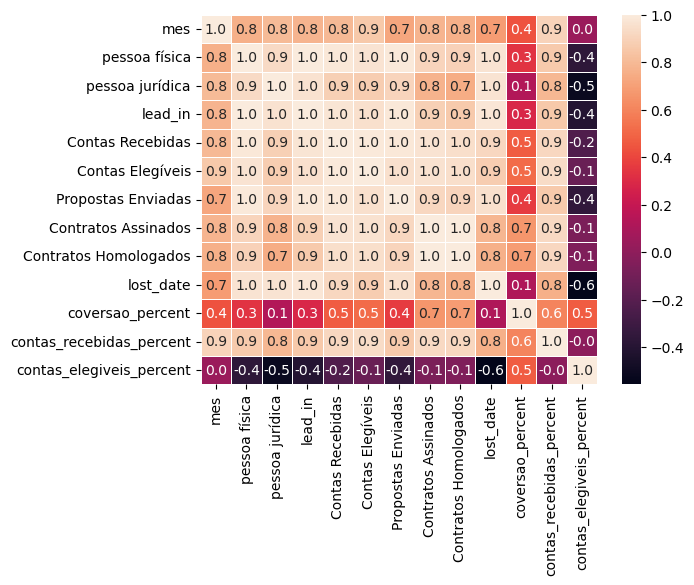

In [20]:
correlation = table_a.corr()
plot = sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=.6)
plot

<AxesSubplot:xlabel='Contas Recebidas', ylabel='Contratos Homologados'>

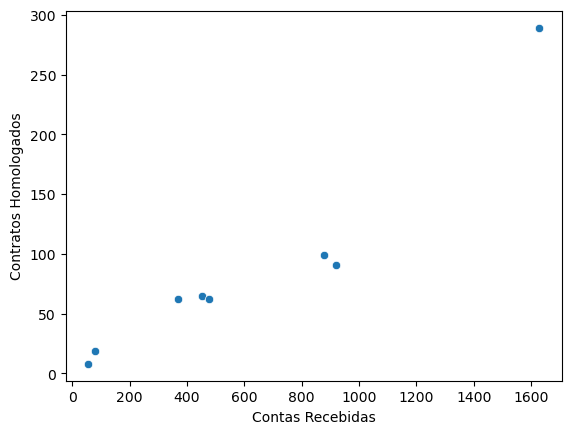

In [21]:
sns.scatterplot(data=table_a,x='Contas Recebidas',y='Contratos Homologados')

<AxesSubplot:xlabel='bill_uploaded', ylabel='homologation_date'>

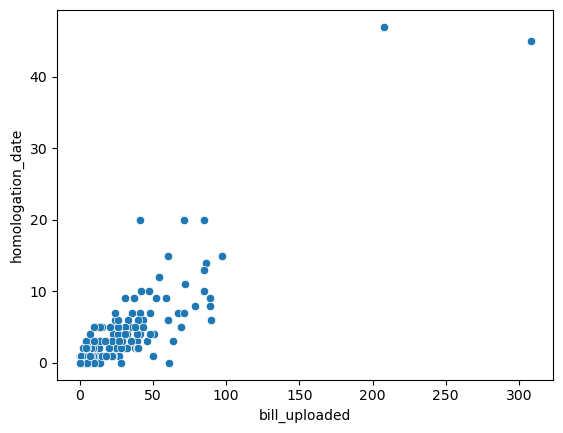

In [22]:
z = df_analise.groupby(['lead_in'],as_index = False)[['bill_uploaded','homologation_date']].count()
sns.scatterplot(data=z,x='bill_uploaded',y='homologation_date')

In [23]:
from statsmodels.tsa.stattools import grangercausalitytests

# Criar exemplo de dados
df = pd.DataFrame(table_a, columns=['contas_recebidas_percent', 'coversao_percent'])

#Aplicando teste de Granger causality
resultados = grangercausalitytests(df, maxlag=2)

print(resultados)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1031  , p=0.7642  , df_denom=4, df_num=1
ssr based chi2 test:   chi2=0.1804  , p=0.6710  , df=1
likelihood ratio test: chi2=0.1782  , p=0.6730  , df=1
parameter F test:         F=0.1031  , p=0.7642  , df_denom=4, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.8789  , p=0.3379  , df_denom=1, df_num=2
ssr based chi2 test:   chi2=46.5463 , p=0.0000  , df=2
likelihood ratio test: chi2=13.0196 , p=0.0015  , df=2
parameter F test:         F=3.8789  , p=0.3379  , df_denom=1, df_num=2
{1: ({'ssr_ftest': (0.10311097710931591, 0.7642054173470956, 4.0, 1), 'ssr_chi2test': (0.18044420994130284, 0.6709917711718534, 1), 'lrtest': (0.17815769839658202, 0.6729612891570467, 1), 'params_ftest': (0.10311097710931515, 0.7642054173470966, 4.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000024ECAD0FB80>, <statsmodels.regression.linear_model.RegressionResul

In [26]:
df = pd.DataFrame(table_a, columns=['pessoa jurídica', 'coversao_percent'])

# Aplicando teste de Granger causality
resultados = grangercausalitytests(df, maxlag=2)

print(resultados)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3025  , p=0.6116  , df_denom=4, df_num=1
ssr based chi2 test:   chi2=0.5293  , p=0.4669  , df=1
likelihood ratio test: chi2=0.5103  , p=0.4750  , df=1
parameter F test:         F=0.3025  , p=0.6116  , df_denom=4, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6882  , p=0.6487  , df_denom=1, df_num=2
ssr based chi2 test:   chi2=8.2584  , p=0.0161  , df=2
likelihood ratio test: chi2=5.1935  , p=0.0745  , df=2
parameter F test:         F=0.6882  , p=0.6487  , df_denom=1, df_num=2
{1: ({'ssr_ftest': (0.30248255703093596, 0.6115964928675555, 4.0, 1), 'ssr_chi2test': (0.5293444748041379, 0.46688258630536605, 1), 'lrtest': (0.5102848367965436, 0.4750155784103054, 1), 'params_ftest': (0.3024825570309355, 0.6115964928675557, 4.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000024ECB074580>, <statsmodels.regression.linear_model.RegressionResults

In [27]:
# Dividindo as variáveis independentes e dependentes
X = table_a[['contas_recebidas_percent','pessoa jurídica']]
y = table_a['coversao_percent']

# Dividindo os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Criando o modelo de regressão linear múltipla
reg = LinearRegression()
reg.fit(X_train, y_train)

# Fazendo previsões
y_pred = reg.predict(X_test)

# Avaliando o desempenho do modelo
r2_score = reg.score(X_test, y_test)
print("R2 Score:", r2_score)
print("Coeficientes: ", reg.coef_)

R2 Score: 0.4965498033829506
Coeficientes:  [ 0.32633662 -0.01864558]
